# Kaggle房价预测比赛

本notebook实现对Kaggle房价预测比赛的解决方案。

In [4]:
# 导入必要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

## 1. 数据加载

In [5]:
# 加载数据
train_data = pd.read_csv('d:/vscode_program/data/kaggle_house_pred_train.csv')
test_data = pd.read_csv('d:/vscode_program/data/kaggle_house_pred_test.csv')

# 查看训练数据的基本信息
print(f"训练数据形状: {train_data.shape}")
print(f"测试数据形状: {test_data.shape}")
train_data.head()

训练数据形状: (1460, 81)
测试数据形状: (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [6]:
# 查看数据的基本统计信息
train_data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
# 检查缺失值
train_missing = train_data.isnull().sum()
test_missing = test_data.isnull().sum()

print("训练数据缺失值:")
print(train_missing[train_missing > 0])
print("\n测试数据缺失值:")
print(test_missing[test_missing > 0])

训练数据缺失值:
LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

测试数据缺失值:
MSZoning           4
LotFrontage      227
Alley           1352
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType       894
MasVnrArea        15
BsmtQual          44
BsmtCond          45
BsmtExposure      44
BsmtFinType1      42
BsmtFinSF1         1
BsmtFinType2      42
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu      730
GarageType        76
GarageYrBlt       78
GarageFinish      78
GarageCars         1
GarageArea         1
Ga

## 2. 数据预处理

In [8]:
# 合并数据集以便统一处理
n_train = train_data.shape[0]
all_data = pd.concat([train_data, test_data], axis=0).reset_index(drop=True)

# 删除ID列
if 'Id' in all_data.columns:
    all_data.drop('Id', axis=1, inplace=True)

In [9]:
# 处理缺失值
# 对于数值型特征，使用中位数填充
numeric_features = all_data.select_dtypes(include=['int64', 'float64']).columns
for feature in numeric_features:
    if all_data[feature].isnull().sum() > 0:
        all_data[feature].fillna(all_data[feature].median(), inplace=True)

# 对于类别型特征，使用众数填充
categorical_features = all_data.select_dtypes(include=['object']).columns
for feature in categorical_features:
    if all_data[feature].isnull().sum() > 0:
        all_data[feature].fillna(all_data[feature].mode()[0], inplace=True)

In [10]:
# 处理类别型特征 - 使用独热编码
all_data = pd.get_dummies(all_data, drop_first=True)

In [11]:
# 分离训练集和测试集
train_features = all_data[:n_train]
test_features = all_data[n_train:]

# 获取目标变量
train_labels = train_data['SalePrice']

# 对目标变量进行对数变换（使分布更接近正态分布）
train_labels = np.log1p(train_labels)

## 3. 模型训练与评估

In [12]:
# 划分训练集和验证集
X_train, X_val, y_train, y_val = train_test_split(train_features, train_labels, test_size=0.2, random_state=42)

In [13]:
# 定义评估函数
def rmse_cv(model, X, y):
    rmse = np.sqrt(-cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [14]:
# 训练多个模型并评估
models = {
    'Linear Regression': LinearRegression(),
    'Ridge': Ridge(alpha=10),
    'Lasso': Lasso(alpha=0.001),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    val_pred = model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    cv_rmse = rmse_cv(model, train_features, train_labels).mean()
    results[name] = {'Validation RMSE': val_rmse, 'CV RMSE': cv_rmse}
    print(f"{name}: Validation RMSE = {val_rmse:.4f}, CV RMSE = {cv_rmse:.4f}")

Linear Regression: Validation RMSE = 0.1015, CV RMSE = 0.1008
Ridge: Validation RMSE = 0.0999, CV RMSE = 0.0861
Lasso: Validation RMSE = 0.1078, CV RMSE = 0.0891
Random Forest: Validation RMSE = 0.0240, CV RMSE = 0.0124
Gradient Boosting: Validation RMSE = 0.0131, CV RMSE = 0.0079
XGBoost: Validation RMSE = 0.0265, CV RMSE = 0.0172
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002667 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3395
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 155
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[

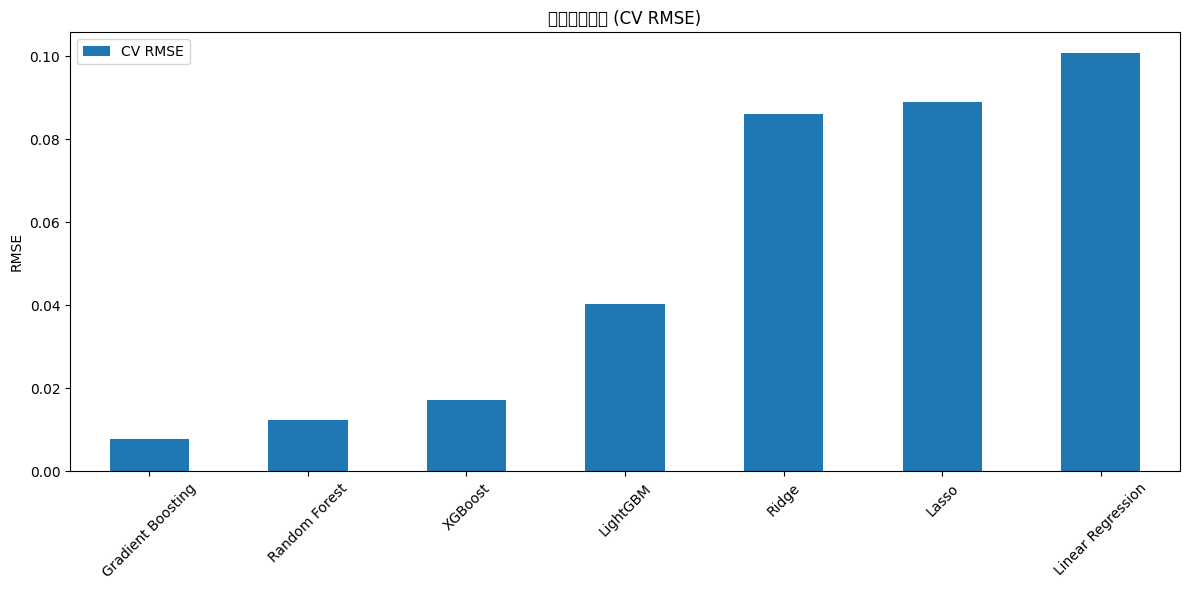

In [15]:
# 可视化模型性能比较
cv_results = pd.DataFrame({name: result['CV RMSE'] for name, result in results.items()}, index=['CV RMSE']).T
cv_results.sort_values('CV RMSE').plot(kind='bar', figsize=(12, 6))
plt.title('模型性能比较 (CV RMSE)')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. 模型融合

In [16]:
# 选择表现最好的几个模型进行融合
best_models = {
    'XGBoost': xgb.XGBRegressor(n_estimators=1000, learning_rate=0.05, random_state=42),
    'LightGBM': lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.05, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
}

# 训练模型
for name, model in best_models.items():
    model.fit(train_features, train_labels)
    print(f"{name} 模型训练完成")

XGBoost 模型训练完成
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3662
[LightGBM] [Info] Number of data points in the train set: 1460, number of used features: 162
[LightGBM] [Info] Start training from score 12.024057
LightGBM 模型训练完成
Gradient Boosting 模型训练完成


In [17]:
# 对测试集进行预测
predictions = {}
for name, model in best_models.items():
    predictions[name] = model.predict(test_features)
    
# 融合预测结果（简单平均）
ensemble_pred = np.mean([predictions[name] for name in best_models.keys()], axis=0)

## 5. 生成提交文件

In [18]:
# 将对数预测转换回原始值
final_predictions = np.expm1(ensemble_pred)

# 创建提交文件
submission = pd.DataFrame({
    'Id': test_data['Id'] if 'Id' in test_data.columns else range(1, len(test_data) + 1),
    'SalePrice': final_predictions
})

# 保存提交文件
submission_path = 'd:/vscode_program/House_price/submission.csv'
submission.to_csv(submission_path, index=False)
print(f"提交文件已保存至: {submission_path}")
submission.head()

提交文件已保存至: d:/vscode_program/House_price/submission.csv


,Id,SalePrice
0,1461,162930.893293
1,1462,163324.837170
2,1463,163133.739850
3,1464,163133.876818
4,1465,163348.808547
